# Capsule Network - EM

# 0. Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
# tf.config.run_functions_eagerly(False)

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
  except RuntimeError as e:
    print(e)

# 1. Parameter

In [3]:
lamda       = 0.01
epochs      = 50
batch_size  = 20
lr          = 0.001
lr_decay_arg= 0.9
optimizer   = tf.keras.optimizers.Adam(lr=lr)

params = {
    'conv_filters'      : 64,
    'caps_primary'      : 8,
    'caps_primary_pose' : 16,
    'caps_conv1'        : 16,       # The number of capsule type (channel) in one layer 
    'caps_conv2'        : 16,       # The number of capsule type (channel) in one layer 
    'n_class_smallNORB' : 5,
    'n_class_MNIST'     : 10,
    'r'                 : 3,
}

# 2. Load SmallNORB / MNIST

## 2.1. MNIST

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = tf.expand_dims(tf.cast(x_train, dtype=tf.float32), axis=-1) / 255.0
x_test = tf.expand_dims(tf.cast(x_test, dtype=tf.float32), axis=-1) / 255.0

x_val, y_val = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

y_train = tf.one_hot(y_train, depth=params['n_class_MNIST'])
y_val = tf.one_hot(y_val, depth=params['n_class_MNIST'])

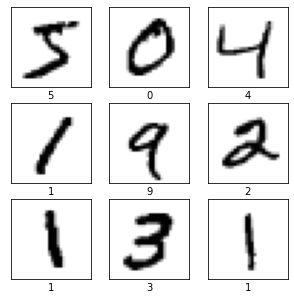

(50000, 28, 28, 1) (50000, 10)


In [5]:
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(np.argmax(y_train[i]))
plt.show()
print(x_train.shape, y_train.shape)

## 2.2. SmallNORB

In [6]:
def load_smallNORB():
    def train_preprocess(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.resize(image, [48, 48])
        image = tf.image.per_image_standardization(image)
        image = tf.image.random_crop(image, [32, 32, 1])
        image = tf.image.random_brightness(image, max_delta=2.0)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)

        label = tf.one_hot(label, depth=params['n_class_smallNORB'])
        return image, label

    def val_proprocess(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.resize(image, [48, 48])
        image = tf.image.per_image_standardization(image)
        image = tf.image.random_crop(image, [32, 32, 1])

        label = tf.one_hot(label, depth=params['n_class_smallNORB'])
        return image, label

    data_train, data_test = tfds.load(
        name = 'smallnorb', 
        split = ['train', 'test'], 
        data_dir = '../data',
        as_supervised = True)

    data_train = data_train.map(train_preprocess).shuffle(2000 + 3*batch_size).batch(batch_size)
    data_test = data_test.map(val_proprocess).batch(batch_size)
    return data_train, data_test

data_train, data_test = load_smallNORB()

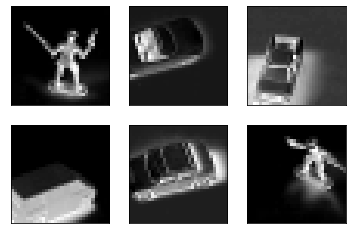

(32, 32, 1)


In [7]:
class_names = ['four-legged animal', 'human figure', 'airplane', 'truck', 'car']

iter = data_train.__iter__()
next = iter.get_next()

plt.figure(figsize=(6, 4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(next[0][i], cmap=plt.cm.binary)
plt.show()
print(next[0][0].shape)

# 3. Capsule Network - EM routing

## 3.1. Primary Capsule

In [8]:
class PrimaryCaps(tf.keras.layers.Layer):
    '''
    This constructs a primary capsule layer using regular convolution layer
    Input: 
        @x:             (None, 14, 14, 32)
    Output: 
        @pose:          (None, 14, 14, 32, 16)
        @activation:    (None, 14, 14, 32, 1)
    '''
    def __init__(self, kernel, stride, n_caps, pose_shape, **kwargs):
        super().__init__(**kwargs)
        self.n_caps     = n_caps
        self.pose_shape = pose_shape

        self.pose       = tf.keras.layers.Conv2D(               # (None, 14, 14, 32, 16)
            filters     = self.n_caps * self.pose_shape,
            kernel_size = kernel, 
            strides     = stride,
            name        = 'PrimaryCapsPose')

        self.activation = tf.keras.layers.Conv2D(               # (None, 14, 14, 32, 1)
            filters     = self.n_caps,
            kernel_size = kernel,
            strides     = stride,
            activation  = 'sigmoid',
            name        = 'PrimaryCapsActivation')
    
    @tf.function
    def call(self, x):                                          # (None, 14, 14, 32)
        with tf.name_scope('CapsuleFormation') as scope:
            pose        = self.pose(x)                          # (None, 14, 14, 32*16)
            pose        = tf.reshape(pose, (-1, pose.shape[1],
                pose.shape[2], self.n_caps, self.pose_shape))   # (None, 14, 14, 32, 16)
            
            activation  = self.activation(x)                    # (None, 14, 14, 32)
            activation  = tf.expand_dims(activation, axis=-1)   # (None, 14, 14, 32, 1)

        return pose, activation

## 3.2. Conv capsule

### 3.2.0. Utilities

In [9]:
def create_routing_map(parent_dim, child_dim, kernel, stride):
    '''
    Create a binary map where the rows are children capsules and columns
    are parents capsules. The binary map shows which children capsules
    are connected to which parent capsules along the spatial dimension
    Input: 
        @parent_dim:    14 
        @child_dim:     6
        @kernel:        3 
        @stride:        1
    Output: 
        @bin_map:       (14x14, 6x6)
    '''
    child_dim2  = int(child_dim**2)
    parent_dim2 = int(parent_dim**2)
    bin_map     = np.zeros((child_dim2, parent_dim2))

    for r in range(parent_dim):
        for c in range(parent_dim):
            p_idx = r * parent_dim + c
            for i in range(kernel):
                c_idx = r * stride * child_dim + \
                    c * stride + \
                    i * child_dim
                bin_map[(c_idx):(c_idx + kernel), p_idx] = 1
    
    return bin_map

In [10]:
def kernel_tile(pose, kernel, stride):
    '''
    Tile the children poses/activations so that the children for each 
    parent occur in one axis
    In case kernel = 3, stride = 2
    Input:
        @pose/activation:   (None, 14, 14, 32, 16/1)
    Output: 
        @tiled:             (None, 6, 6, 9, 32, 16/1
        @child_parent_mat:  (14x14, 6x6)
    '''
    # Setup values
    kernel2     = int(kernel**2)

    child_dim   = pose.shape[1]
    child_dim2  = int(child_dim**2)
    child_caps  = pose.shape[3]
    child_vect  = pose.shape[4]

    parent_dim  = int((child_dim - kernel) / stride + 1)

    # Matrix showing which children map to which parent. 
    # Children are rows, parents are columns.
    child_parent_mat = create_routing_map(                  # (14*14, 6*6)
        parent_dim, child_dim, kernel, stride)

    # Parents are rows, indexes in the row are children
    tmp = np.where(np.transpose(child_parent_mat))
    child_to_parent_idx = np.reshape(tmp[1],                # (6*6, 3*3)
        [child_parent_mat.shape[1], -1])                        

    # Spread out spatial dimension of children
    pose = tf.reshape(pose,                                 # (None, 14*14, 32*16)
        [-1, child_dim2, child_caps * child_vect])           

    # Select which children go to each parent
    tiled = tf.gather(pose, child_to_parent_idx, axis=1)    # (None, 6*6, 3*3, 32*16)
    tiled = tf.squeeze(tiled)

    tiled = tf.reshape(tiled,                               # (None, 6, 6, 3*3, 32, 16)
        [-1, parent_dim, parent_dim, 
        kernel2, child_caps, child_vect])                                     

    return tiled, child_parent_mat

In [11]:
def to_sparse(probs, routing_matrix, sparse_filler=tf.math.log(1e-20)):
    '''
    Convert probs tensor to sparse along child_dim dimension
    Input:
        @probs:             (None, 6, 6, 9, 32, 32)
        @routing_matrix:    (14*14, 6*6)
    Output:            
        @sparse:            (None, 6, 6, 14*14, 32, 32)
    '''
    # Setup values
    kernel2     = probs.shape[3]

    child_dim2  = routing_matrix.shape[0]
    child_caps  = probs.shape[4]

    parent_dim  = probs.shape[1]
    parent_dim2 = routing_matrix.shape[1]
    parent_caps = probs.shape[5]
    
    # Start converting
    probs_flat = tf.reshape(probs,                              # (None, 6*6, 9, 32, 32)
        [-1, parent_dim2, kernel2, child_caps, parent_caps])

    tmp = np.where(np.transpose(routing_matrix))
    child_to_parent_idx = np.reshape(tmp[1],                    # (6*6, 3*3)
        [routing_matrix.shape[1], -1])

    child_sparse_idx = child_to_parent_idx[np.newaxis, ...]     # (1, 6*6, 3*3)
    child_sparse_idx = np.tile(child_sparse_idx,                # (None, 6*6, 3*3)
        [batch_size, 1, 1])

    parent_idx = np.arange(parent_dim2)
    parent_idx = np.reshape(parent_idx, [-1, 1])
    parent_idx = np.repeat(parent_idx, kernel2)
    parent_idx = np.tile(parent_idx, batch_size)
    parent_idx = np.reshape(parent_idx,                         # (None, 6*6, 3*3)
        [-1, parent_dim2, kernel2])

    batch_idx = np.arange(batch_size)
    batch_idx = np.reshape(batch_idx, [-1, 1])
    batch_idx = np.tile(batch_idx, parent_dim2 * kernel2)
    batch_idx = np.reshape(batch_idx,                           # (None, 6*6, 3*3)
        [-1, parent_dim2, kernel2])

    # Combine 3 coordinates
    indices = tf.constant(                                      # (None, 6*6, 3*3, 3)
        np.stack((batch_idx, parent_idx, child_sparse_idx), axis=3))

    # Convert each spatial location to sparse
    shape = [batch_size, parent_dim2, child_dim2, child_caps, parent_caps]
    sparse = tf.scatter_nd(indices, probs_flat, shape)
    zeros  = tf.ones_like(sparse, dtype=tf.float32) * sparse_filler
    sparse = tf.where(tf.equal(sparse, 0.0), zeros, sparse)     # (None, 6*6, 14*14, 32, 32)

    sparse = tf.reshape(sparse,                                 # (None, 6, 6, 14*14, 32, 32)
        [-1, parent_dim, parent_dim, child_dim2, child_caps, parent_caps])
        
    return sparse

### 3.2.1. EM-routing

In [12]:
def m_step(rr, vote_ij, activation_i, lamda, beta_v, beta_a):
    '''
    M-step in EM routing between input capsules [i] and output capsules [j].
    Input:
        @rr:            (1, 6, 6, 9*32, 32, 1)
        @vote_ij:       (None, 6, 6, 9*32, 32, 16)
        @activation_i:  (None, 6, 6, 9*32, 1, 1)
    Output:
        @activation_j:  (None, 6, 6, 1, 32, 1)
        @mean_j:        (None, 6, 6, 1, 32, 16)
        @stddev_j       (None, 6, 6, 1, 32, 16)
    '''
    rr      = rr * activation_i                         # (None, 6, 6, 9*32, 32, 1)
    rr_sum  = tf.reduce_sum(rr, axis=3, keepdims=True)  # (None, 6, 6, 1, 32, 1)

    mean_j  = tf.reduce_sum(                            # (None, 6, 6, 1, 32, 16)
        rr * vote_ij, axis=3, keepdims=True) / rr_sum   

    stddev_j = tf.reduce_sum(                           # (None, 6, 6, 1, 32, 16)
        rr * tf.square(vote_ij - mean_j), axis=3, keepdims=True) / rr_sum
    stddev_j = stddev_j + 1e-9

    cost_h = (beta_v + tf.math.log(stddev_j)) * rr_sum  # (None, 6, 6, 1, 32, 16)
    cost_h_sum = tf.reduce_sum(cost_h,                  # (None, 6, 6, 1, 32, 1)
        axis=-1, keepdims=True) 

    activation_j = tf.sigmoid(                          # (None, 6, 6, 1, 32, 1)
        lamda * (beta_a - cost_h_sum))

    return activation_j, mean_j, stddev_j

In [13]:
def e_step(vote_ij, activation_j, mean_j, stddev_j, routing_matrix):
    '''
    E-step in EM routing between input capsules [i] and output capsules [j].
    Input:
        @vote_ij:       (None, 6, 6, 9*32, 32, 16)
        @activation_j:  (None, 6, 6, 1, 32, 1)
        @mean_j:        (None, 6, 6, 1, 32, 16)
        @stddev_j:      (None, 6, 6, 1, 32, 16)
        @routing_matrix:(14*14, 6*6)
    Output: 
        @rr_new_mask:   (None, 6, 6, 9*32, 32, 1)
    '''
    # Setup values
    kernel2     = int(np.sum(routing_matrix[:,0]))
    
    child_dim2  = routing_matrix.shape[0]
    child_caps  = int(vote_ij.shape[3] / kernel2)
    
    parent_dim  = vote_ij.shape[1]
    parent_dim2 = routing_matrix.shape[1]
    parent_caps = vote_ij.shape[4]
    
    log_p_unit0 = -tf.reduce_sum(                       # (None, 6, 6, 9*32, 32, 1)
        tf.square(vote_ij - mean_j) / (2 * stddev_j),
        axis=-1, keepdims=True)
    log_p_unit1 = - 0.5 * tf.reduce_sum(                # (None, 6, 6, 9*32, 32, 1)
        tf.math.log(2 * np.pi * stddev_j),
        axis=-1, keepdims=True)
    log_p = log_p_unit0 + log_p_unit1                   # (None, 6, 6, 9*32, 32, 1)

    rr_new = tf.math.log(activation_j + 1e-9) + log_p   # (None, 6, 6, 9*32, 32, 1)
    rr_new = tf.reshape(rr_new,                         # (None, 6, 6, 9, 32, 32)
        [-1, parent_dim, parent_dim, 
        kernel2, child_caps, parent_caps])

    # Normalizing across parents
    # In 3th dim of rr_new are 9 children of the parent capsule, in order to normalize rr_new 
    # correctly, we have to transform it to the sparse form, which is 14*14 in that dimension.
    # Then we calculate softmax along all parents' dimension. Then transform it back to the 
    # dense form, which is 9
    # 1. Tranform to sparse form
    sparse_filler = tf.minimum(tf.reduce_min(rr_new), -100)
    rr_new = to_sparse(                                 # (None, 6, 6, 14*14, 32, 32)
        rr_new, routing_matrix, sparse_filler)

    # 2. Softmax
    rr_new = tf.transpose(                              # We swap all axis related to parent to the end
        rr_new, perm=[0, 3, 4, 1, 2, 5])                # (None, 14*14, 32, 6, 6, 32)
    rr_new = tf.reshape(rr_new,                         # (None, 14*14, 32, 6*6*32)
        [-1, child_dim2, child_caps, parent_dim2 * parent_caps])       
    rr_new = tf.nn.softmax(                             # (None, 14*14, 32, 6*6*32)
        rr_new, axis=-1)
    rr_new = tf.reshape(rr_new,                         # (None, 14*14, 32, 6, 6, 32)
        [-1, child_dim2, child_caps, 
        parent_dim, parent_dim, parent_caps])
    rr_new = tf.transpose(rr_new,                       # (None, 6, 6, 14*14, 32, 32)
        [0, 3, 4, 1, 2, 5])

    # 3. Transform back to dense form
    rr_new = tf.reshape(rr_new,                         # (None, 6*6, 14*14, 32, 32)
        [-1, parent_dim2, child_dim2, 
        child_caps, parent_caps])
    rr_new_mask = tf.boolean_mask(rr_new, tf.transpose(routing_matrix), axis=1)
    rr_new_mask = tf.reshape(rr_new_mask,               # (None, 6, 6, 9*32, 32, 1)
        [-1, parent_dim, parent_dim, 
        kernel2 * child_caps, parent_caps, 1])

    return rr_new_mask

In [14]:
def init_rr(routing_matrix, child_caps, parent_caps):
    '''
    Initialize routing weights taking into account spatial position of 
    child capsules. Child capsules in the corners only go to one parent 
    capsule, while those in the middle can go to kernel*kernel capsules.
    Input:
        @routing_matrix: (14*14, 6*6)
    Output:
        @rr_init:        (1, 6, 6, 9, 32, 32)
    '''
    parent_dim = int(np.sqrt(routing_matrix.shape[1]))

    # Count the number of parents that each child belongs to
    parents_per_child = np.sum(
        routing_matrix, axis=1, keepdims=True)       # (14*14, 1)
    
    # Divide the vote of each child by the number of ALL parents
    rr_init = routing_matrix / (parents_per_child * parent_caps + 1e-9)     # (14*14, 6*6)
    
    # Convert rr_init to be compatible with votes
    mask    = routing_matrix.astype(bool)                                   # (14*14, 6*6)
    rr_init = rr_init.T[mask.T]                                             # (6*6*9, )
    
    rr_init = np.reshape(rr_init, [parent_dim, parent_dim, -1])             # (6, 6, 9)
    rr_init = rr_init[..., np.newaxis, np.newaxis]                          # (6, 6, 9, 1, 1)        
    rr_init = np.tile(rr_init, [1, 1, 1, child_caps, parent_caps])          # (6, 6, 9, 32, 32)
    rr_init = np.expand_dims(rr_init, 0)                                    # (1, 6, 6, 9, 32, 32)

    return rr_init

def em_routing(vote_ij, activation_i, routing_matrix, r, beta_v, beta_a):
    '''
    The EM routing between input capsules [i] and output capsules [j].
    Input:
        @vote_ij:       (None*6*6, 9*32, 32, 16)
        @activation_i:  (None*6*6, 9*32, 1)
        @routing_matrix:(14*14, 6*6)
    '''
    # Setup values
    kernel2     = int(np.sum(routing_matrix[:,0]))
    child_caps  = int(vote_ij.shape[1] / kernel2)

    parent_dim  = int(np.sqrt(routing_matrix.shape[1]))
    parent_caps = vote_ij.shape[2]

    # Initialize vote_ij, activation_i
    vote_ij         = tf.reshape(vote_ij,                   # (None, 6, 6, 9*32, 32, 16)
        [-1, parent_dim, parent_dim,
        vote_ij.shape[1], vote_ij.shape[2], vote_ij.shape[3]])
    activation_i    = tf.reshape(activation_i,              # (None, 6, 6, 9*32, 1, 1)
        [-1, parent_dim, parent_dim,
        activation_i.shape[1], 1, 1])
    
    # Initialize routing assignments
    rr = init_rr(                                           # (1, 6, 6, 9, 32, 32)
        routing_matrix, child_caps, parent_caps)
    rr = np.reshape(rr,                                     # (1, 6, 6, 9*32, 32, 1)
        [1, parent_dim, parent_dim, 
        kernel2 * child_caps, parent_caps, 1])
    rr = tf.constant(rr, dtype=tf.float32)

    # Start routing iteration
    for it in range(r):
        # https://openreview.net/forum?id=HJWLfGWRb
        lamda_schedule = (lamda * (1 - tf.pow(0.95, tf.cast(it + 1, tf.float32))))
        
        # M-step
        # @activation_j :(None, 6, 6, 1, 32, 1)
        # @mean_j       :(None, 6, 6, 1, 32, 16)
        # @stddev_j     :(None, 6, 6, 1, 32, 16)
        activation_j, mean_j, stddev_j = m_step(
            rr, vote_ij, activation_i, lamda_schedule, beta_v, beta_a)

        # E-step
        # @rr           :(None, 6, 6, 9*32, 32, 1)
        if (it < r - 1):
            rr = e_step(
                vote_ij, activation_j, mean_j, stddev_j, routing_matrix)
    
    pose_j          = tf.squeeze(mean_j, axis=-3)           # (None, 6, 6, 32, 16)
    activation_j    = tf.squeeze(activation_j, axis=-3)     # (None, 6, 6, 32, 1)

    return pose_j, activation_j

### 3.2.2. Conv Capsule Implementation

In [15]:
class ConvCaps(tf.keras.layers.Layer):
    '''
    This contructs a convolution capsule layer from a primary capsule layer
    In case, kernel = 3, stride = 2
    Input:
        @pose:          (None, 14, 14, 32, 16)
        @activation:    (None, 14, 14, 32, 1)
    Output: 
        @pose:          (None, 6, 6, 32, 16)
        @activation:    (None, 6, 6, 32, 1)
    '''
    def __init__(self, kernel, stride, n_caps, r=3, **kwargs):
        super().__init__(**kwargs)
        self.kernel         = kernel
        self.kernel2        = int(kernel ** 2)
        self.stride         = stride
        self.parent_caps    = n_caps
        self.r              = r

    def build(self, input_shape):
        pose_shape, activation_shape = input_shape                  # (None, 14, 14, 32, 16), (None, 14, 14, 32, 1)
        self.child_dim      = pose_shape[1]
        self.child_caps     = pose_shape[3]
        self.parent_dim     = int(np.floor((self.child_dim - self.kernel) / self.stride + 1))
        self.parent_dim2    = int(self.parent_dim ** 2)

        self.W = self.add_weight(                                   # (1, 9*32, 32, 4, 4)
            shape       = [1, self.kernel2 * self.child_caps, self.parent_caps, 4, 4],
            initializer = tf.keras.initializers.TruncatedNormal(
                mean    = 0.0,
                stddev  = 1.0),
            dtype       = tf.float32,
            name        = 'ConvCaps_W',
            trainable   = True)
        
        self.beta_a = self.add_weight(                              # (1, 1, 1, 1, 32, 1)
            shape       = [1, 1, 1, 1, self.parent_caps, 1],
            initializer = tf.keras.initializers.TruncatedNormal(
                mean    = -1000.0,
                stddev  = 500.0),
            dtype       = tf.float32,
            name        = 'ConvCaps_beta_a',
            trainable   = True)

        self.beta_v = self.add_weight(                              # (1, 1, 1, 1, 32, 1)
            shape       = [1, 1, 1, 1, self.parent_caps, 1],
            initializer = tf.keras.initializers.GlorotNormal(),
            dtype       = tf.float32,
            name        = 'ConvCaps_beta_v',
            trainable   = True)

        self.built = True

    @tf.function
    def call(self, x):
        pose_i, activation_i = x                                    # (None, 14, 14, 32, 16), (None, 14, 14, 32, 1)

        with tf.name_scope('Tile') as scope:
            pose_tiled, routing_matrix = kernel_tile(               # (None, 6, 6, 9, 32, 16), (14*14, 6*6)
                pose_i, self.kernel, self.stride)
            activation_tiled, _        = kernel_tile(               # (None, 6, 6, 9, 32, 1)
                activation_i, self.kernel, self.stride)

        pose_flat         = tf.reshape(pose_tiled,                  # (None*6*6, 9*32, 1, 4, 4)
            [-1, self.kernel2 * self.child_caps, 1, 4, 4])
        activation_flat   = tf.reshape(activation_tiled,            # (None*6*6, 9*32, 1)
            [-1, self.kernel2 * self.child_caps, 1])

        with tf.name_scope('Vote') as scope:
            vote_ij     = pose_flat @ self.W                        # (None*6*6, 9*32, 32, 4, 4)
            vote_ij     = tf.reshape(vote_ij,                       # (None*6*6, 9*32, 32, 16)
                [-1, self.kernel2 * self.child_caps, self.parent_caps, 16])

        # EM-routing
        pose_j, activation_j = em_routing(                          # ((None, 6, 6, 32, 16), (None, 6, 6, 32, 1))
            vote_ij, activation_flat, routing_matrix, 
            self.r, self.beta_v, self.beta_a)

        return pose_j, activation_j

## 3.3. Class Capsule

In [16]:
def coord_addition(vote):
    '''
    This contructs the coordinate addition for connecting the last convolutional 
    capsule layer to the final layer
    "When connecting the last convolutional capsule layer to the final layer we do 
    not want to throw away information about the location of the convolutional 
    capsules but we also want to make use of the fact that all capsules of the 
    same type are extracting the same entity at different positions. We therefore   
    share the transformation matrices between different positions of the same 
    capsule type and add the scaled coordinate (row, column) of the center of the   
    receptive field of each capsule to the first two elements of the right-hand 
    column of its vote matrix. We refer to this technique as Coordinate Addition.   
    This should encourage the shared final transformations to produce values for 
    those two elements that represent the fine position of the entity relative to   
    the center of the capsule’s receptive field."

    Input:
        @vote: (None, 4, 4, 32, 5, 16)
    Output:
        @vote: (None, 4, 4, 32, 5, 16)
    '''
    h           = vote.shape[1]
    w           = vote.shape[2]
    dim         = vote.shape[-1]

    h_offset = np.zeros((h, dim))
    h_offset[:, 3] = (np.arange(h) + 0.5) / h
    h_offset = np.reshape(h_offset, [1, 1, h, 1, 1, dim])
    
    w_offset = np.zeros((w, dim))
    w_offset[:, 7] = (np.arange(w) + 0.5) / w
    w_offset = np.reshape(w_offset, [1, 1, w, 1, 1, dim])

    offset = tf.constant(h_offset + w_offset, dtype=tf.float32)

    vote = vote + offset

    return vote

In [17]:
class ClassCaps(tf.keras.layers.Layer):
    '''
    This constructs the last capsule layer which has one capsule per output class
    @input: (pose, activation) = ((None, 4, 4, 32, 16), (None, 4, 4, 32, 1))
    @output: (pose, activation) = ((None, n_class, 16), (None, n_class))
    '''
    def __init__(self, n_caps, r=3, **kwargs):
        super().__init__(**kwargs)
        self.parent_caps    = n_caps
        self.r              = r

    def build(self, input_shape):
        pose_shape, activation_shape = input_shape              # ((None, 4, 4, 32, 16), (None, 4, 4, 32, 1))
        self.child_dim      = pose_shape[1]
        self.child_dim2     = int(self.child_dim ** 2)
        self.child_caps     = pose_shape[3]

        self.W = self.add_weight(                               # (1, 32, 5, 4, 4)
            shape       = [1, self.child_caps, self.parent_caps, 4, 4],
            initializer = tf.keras.initializers.TruncatedNormal(
                mean    = 0.0,
                stddev  = 1.0),
            dtype       = tf.float32,
            name        = 'ClassCaps_W',
            trainable   = True)

        self.beta_a = self.add_weight(                          # (1, 1, 1, 1, 5, 1)
            shape       = [1, 1, 1, 1, self.parent_caps, 1],
            initializer = tf.keras.initializers.TruncatedNormal(
                mean    = -1000.0,
                stddev  = 500.0),
            dtype       = tf.float32,
            name        = 'ClassCaps_beta_a',
            trainable   = True)

        self.beta_v = self.add_weight(                          # (1, 1, 1, 1, 5, 1)
            shape       = [1, 1, 1, 1, self.parent_caps, 1],
            initializer = tf.keras.initializers.GlorotNormal(),
            dtype       = tf.float32,
            name        = 'ClassCaps_beta_v',
            trainable   = True)

        self.built = True

    @tf.function
    def call(self, x):                                          
        pose_i, activation_i = x                                # ((None, 4, 4, 32, 16), (None, 4, 4, 32, 1))

        pose_flat   = tf.reshape(pose_i,                        # (None*4*4, 32, 1, 4, 4)
            [-1, self.child_caps, 1, 4, 4])

        with tf.name_scope('Vote') as scope:
            vote        = pose_flat @ self.W                    # (None*4*4, 32, 5, 4, 4)
            vote        = tf.reshape(vote,                      # (None, 4, 4, 32, 5, 16)
                [-1, self.child_dim, self.child_dim,
                self.child_caps, self.parent_caps, 16])
            vote        = coord_addition(vote)                  # (None, 4, 4, 32, 5, 16)

        vote_flat       = tf.reshape(vote,                      # (None, 4*4*32, 5, 16)
            [-1, self.child_dim2 * self.child_caps, self.parent_caps, 16])
        activation_flat = tf.reshape(activation_i,              # (None, 4*4*32, 1)
            [-1, self.child_dim2 * self.child_caps, 1])

        # EM-routing
        routing_matrix  = create_routing_map(1, 1, 1, 1)        # (1, 1): This is just a dummy
        pose_j, activation_j = em_routing(                      # ((None, 1, 1, 5, 16), (None, 1, 1, 5, 1))
            vote_flat, activation_flat, routing_matrix,
            self.r, self.beta_v, self.beta_a)

        pose_j          = tf.squeeze(pose_j, axis=[1, 2])
        activation_j    = tf.squeeze(activation_j, axis=[1, 2, 4])

        return pose_j, activation_j

## 3.4. Model

In [18]:
class CapsuleNetwork(tf.keras.Model):
    def __init__(self, params, **kwargs):
        super().__init__(**kwargs)
        self.conv_filters       = params['conv_filters']
        self.caps_primary       = params['caps_primary']
        self.caps_primary_pose  = params['caps_primary_pose']
        self.caps_conv1         = params['caps_conv1']
        self.caps_conv2         = params['caps_conv2']
        self.caps_class         = params['n_class_smallNORB']
        self.r                  = params['r']

        with tf.name_scope('Variables') as scope:
            # ReLU Conv1
            # Input: (None, 28, 28, 1)
            # Output: (None, 14, 14, 32)
            self.conv = tf.keras.layers.Conv2D(
                filters         = self.conv_filters,
                kernel_size     = 5,
                strides         = 2,
                padding         = 'same',
                activation      = 'relu',
                name            = 'ConvolutionLayer')

            # Primary Capsule
            # Input: (None, 14, 14, 32)
            # Output: (pose, activation) = ((None, 14, 14, 32, 16), (None, 14, 14, 32, 1))
            self.caps_primary = PrimaryCaps(
                kernel      = 1,
                stride      = 1,
                n_caps      = self.caps_primary,
                pose_shape  = self.caps_primary_pose)

            # Conv Capsule 1
            # Input: (pose, activation) = ((None, 14, 14, 32, 16), (None, 14, 14, 32, 1))
            # Output: (pose, activation) = ((None, 6, 6, 32, 16), (None, 6, 6, 32, 1))
            self.caps_conv1 = ConvCaps(
                kernel = 3,
                stride = 2,
                n_caps = self.caps_conv1
            )

            # Conv Capsule 2
            # Input: (pose, activation) = ((None, 6, 6, 32, 16), (None, 6, 6, 32, 1))
            # Output: (pose, activation) = ((None, 4, 4, 32, 16), (None, 4, 4, 32, 1))
            self.caps_conv2 = ConvCaps(
                kernel = 3,
                stride = 1,
                n_caps = self.caps_conv2
            )

            # Final Capsule - class capsule
            # Input: (pose, activation) = ((None, 4, 4, 32, 16), (None, 4, 4, 32, 1))
            # Output: (pose, activation) = ((None, 5, 16), (None, 5,))
            self.caps_class = ClassCaps(
                n_caps = self.caps_class
            )

    def build(self, input_shape):
        pass

    def call(self, data):
        '''
            data.shape: (None, 28, 28, 1)
        '''
        x = self.conv(data)         # (None, 14, 14, 32)
        x = self.caps_primary(x)    # ((None, 14, 14, 32, 16), (None, 14, 14, 32, 1))
        x = self.caps_conv1(x)      # ((None, 6, 6, 32, 16), (None, 6, 6, 32, 1))
        x = self.caps_conv2(x)      # ((None, 4, 4, 32, 16), (None, 4, 4, 32, 1))
        x = self.caps_class(x)      # ((None, 10, 16), (None, 10,))

        return x[1]

model = CapsuleNetwork(params)

## 3.5. Loss Function
### Spread loss

In [19]:
margin = 0.2

@tf.function
def spread_loss(y_true, activation):
    '''
    Input:
        @y_true: (None, 10)
        @activation: (None, 10)
    Output:
        spread loss
    '''
    mask_t = tf.equal(y_true, 1)
    mask_i = tf.equal(y_true, 0)

    activation_t = tf.reshape(
        tf.boolean_mask(activation, mask_t),
        [-1, 1])
    
    activation_i = tf.reshape(
        tf.boolean_mask(activation, mask_i),
        [-1, activation.shape[1] - 1])
    
    L = tf.reduce_sum(
        tf.square(
            tf.maximum(
                0.0, margin - (activation_t - activation_i)
            )))
    
    return L

## 3.4. Training Model

### 3.4.1. Log + Checkpoint

In [20]:
# Create checkpoint object
log_dir = './logs/param'
log = tf.keras.callbacks.CSVLogger(
    log_dir + '/log.csv')

checkpoint_dir = './logs/model'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_dir + '/weights-{epoch:02d}.h5',
    monitor             = 'val_accuracy',
    save_best_only      = True,
    save_weights_only   = True,
    verbose             = 1)

### 3.4.2. Scheduler

In [21]:
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    schedule            = lambda epoch: lr * (lr_decay_arg ** epoch))

In [22]:
# Scheduler to increase margin by 0.1 from 0.2 to 0.9 for every epoch
def margin_update():
    global margin
    if margin < 0.9:
        margin += 0.1

margin_scheduler = tf.keras.callbacks.LambdaCallback(
    on_epoch_end = lambda epoch, logs: margin_update())

### 3.4.3. Visualization

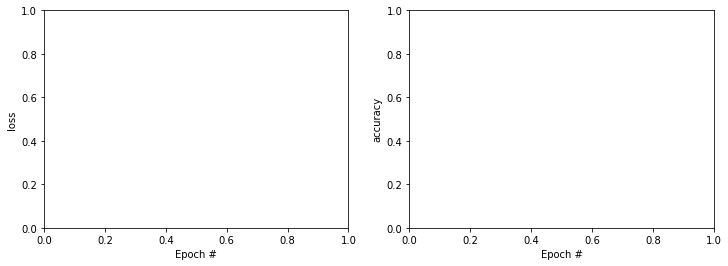

In [23]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('loss')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('accuracy')

class TrainingPlot(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding losses
        self.losses     = []
        self.accuracy   = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs['loss'])
        self.accuracy.append(logs['accuracy'])
        
        epochs = np.arange(epoch + 1)
        ax1.plot(epochs, self.losses, 'b-')
        ax2.plot(epochs, self.accuracy, 'b-')
        fig.canvas.draw()

In [24]:
def train(model):
    model.compile(
        optimizer       = tf.keras.optimizers.Adam(lr=lr),
        loss            = [spread_loss],
        loss_weights    = [1.0],
        metrics         = {'output_1': 'accuracy'})

    history = model.fit(
        data_train,
        epochs          = epochs,
        validation_data = data_test,
        callbacks       = [log, checkpoint, lr_decay, margin_scheduler],
        verbose         = 1)

In [25]:
train(model)

Epoch 1/50
500/500 [==============================] - 1279s 2s/step - loss: 3.1178 - accuracy: 0.1834 - val_loss: 2.2638 - val_accuracy: 0.2070

Epoch 00001: val_accuracy improved from -inf to 0.20700, saving model to ./logs/model\weights-01.h5
Epoch 2/50
500/500 [==============================] - 1291s 3s/step - loss: 2.0167 - accuracy: 0.1969 - val_loss: 2.0814 - val_accuracy: 0.1866

Epoch 00002: val_accuracy did not improve from 0.20700
Epoch 3/50
500/500 [==============================] - 31203s 63s/step - loss: 1.8430 - accuracy: 0.2041 - val_loss: 1.8455 - val_accuracy: 0.2180

Epoch 00003: val_accuracy improved from 0.20700 to 0.21800, saving model to ./logs/model\weights-03.h5
Epoch 4/50
500/500 [==============================] - 273s 546ms/step - loss: 1.7605 - accuracy: 0.2183 - val_loss: 1.9268 - val_accuracy: 0.2076

Epoch 00004: val_accuracy did not improve from 0.21800
Epoch 5/50
500/500 [==============================] - 274s 547ms/step - loss: 1.7950 - accuracy: 0.2099

KeyboardInterrupt: 

In [26]:
print(margin)

0.7
